In [1]:
## Overview 

In [2]:
### Import Libraries
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import decomposition
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score 
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import time
import sys
import glob
sys.path.insert(0,'../../../../../utils/')
from helper_functions import *
#import helper_function custom library
from model_builder import ModelBuilder
pd.options.mode.chained_assignment = None
%matplotlib inline 

In [3]:
### Import and Clean Data
#load spectra data
df_aug = pd.read_csv("../../../../../data/refCanopies0802_0630.txt")
df_sep = pd.read_csv("../../../../../data/refCanopies0917_0630.txt")
df_oct = pd.read_csv("../../../../../data/refCanopies1016_0630.txt")

#load tree data
df_tree = pd.read_csv("../../../../../data/Export_Output_2_0630.txt")

In [13]:
df_tree

,OBJECTID,SPECIES,SHAPE_Length,SHAPE_Area
0,1,PINI,37.679794,87.098934
1,2,PINI,20.187900,29.392963
2,3,PINI,25.225593,34.486873
3,4,PINI,17.967286,21.399646
4,5,PINI,14.689557,15.861266
...,...,...,...,...
1054,1067,CECA,11.892819,9.338367
1055,1068,CECA,10.860347,8.001629
1056,1069,CECA,12.133778,10.770917
1057,1070,CECA,12.708083,11.840115


In [4]:
#clean data
#removes non-vegatation pixels, tRef.NDVI = (tRef.x800_67 - tRef.x679_92) ./ (tRef.x800_67 + tRef.x679_92)
#removes shaded or dark pixels as well, (pixel's reflectance@800_67 <=0.15)
df_aug = data_cleaning(df_tree,df_aug)
df_sep = data_cleaning(df_tree,df_sep)
df_oct = data_cleaning(df_tree,df_oct)

In [5]:
#evaluate the model
#create a confusion matrix
labels = ['Sugar Maple', "Eastern Redbud", "Green Ash", 'Norway Spruce','Austrian Pine','Ponderosa Pine',
          'Colorado Spruce', 'Scotch Pine','White Oak','Bur Oak', 'Red Oak']
nclasses = 11

#hold metrics
evals = []

In [6]:
df_aug.head(3)

,ROIID,IDwithROI,396.33,398.01,399.7,401.38,403.07,404.75,406.44,408.13,...,886.78,888.5,890.22,891.94,893.66,895.38,897.1,898.81,900.53,TARGET
2,1,3,-0.0028,-0.0016,-0.0002,0.0014,0.0032,0.0052,0.0075,0.0092,...,0.2337,0.2359,0.2388,0.2425,0.247,0.2526,0.2440,0.2447,0.2451,PINI
3,1,4,-0.0028,-0.0016,-0.0002,0.0014,0.0032,0.0052,0.0075,0.0092,...,0.2337,0.2359,0.2388,0.2425,0.247,0.2526,0.2440,0.2447,0.2451,PINI
4,1,5,0.0064,0.0058,0.0057,0.0058,0.0065,0.0078,0.0080,0.0078,...,0.3018,0.3044,0.3063,0.3079,0.309,0.3098,0.3109,0.3117,0.3106,PINI


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished


           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
1032  1.085442 -0.152879  0.027958 -0.075921 -0.038673 -0.008437  0.034097   
1033 -0.118584 -0.095233  0.024711 -0.017933 -0.022466  0.000507  0.001983   
1034  0.320678 -0.165289  0.007905 -0.043325 -0.023317 -0.010924  0.021089   
1035  0.090808 -0.134599  0.052237 -0.039576 -0.023120 -0.001072  0.016289   
1036 -1.425835 -0.074556  0.034194 -0.029856 -0.015372 -0.001469 -0.007395   

           PC8       PC9      PC10  ...      PC22      PC23      PC24  \
1032  0.021671  0.016691 -0.010665  ...  0.002878 -0.000468  0.002696   
1033  0.020644  0.006365 -0.010139  ...  0.001722  0.001012  0.001414   
1034  0.007797  0.009510  0.009591  ...  0.001590  0.000816 -0.001674   
1035  0.012299  0.002460 -0.002077  ... -0.001886 -0.000255  0.000150   
1036 -0.008123  0.010430  0.000745  ...  0.000346 -0.000535 -0.000597   

          PC25      PC26      PC27      PC28      PC29      PC30  target  
1032 -0.001042  0

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.1s finished


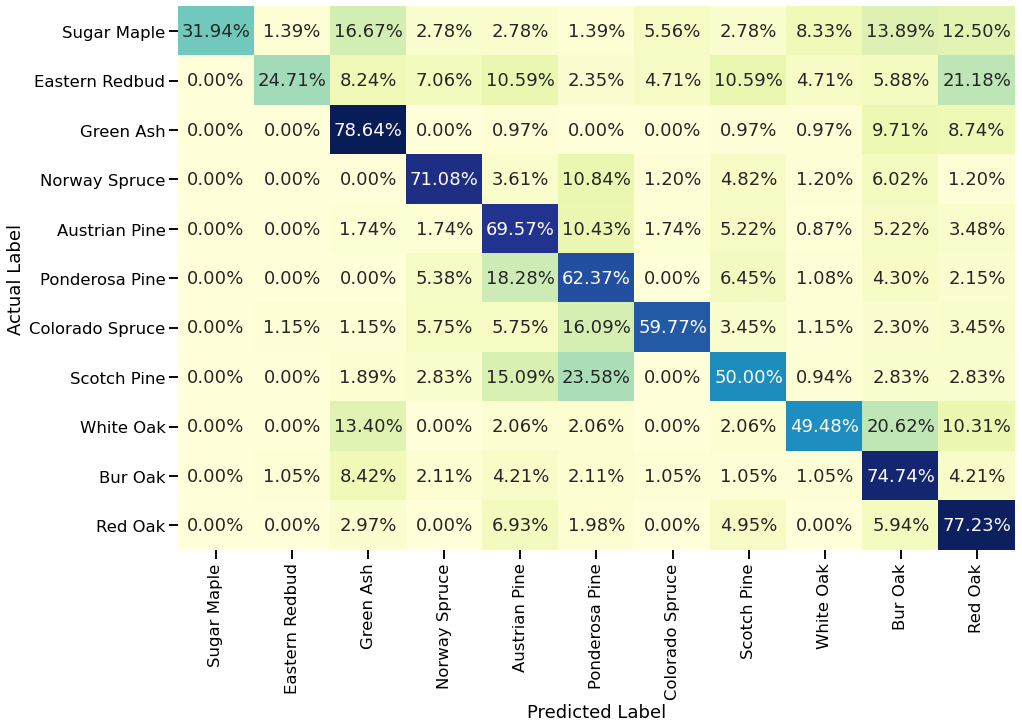

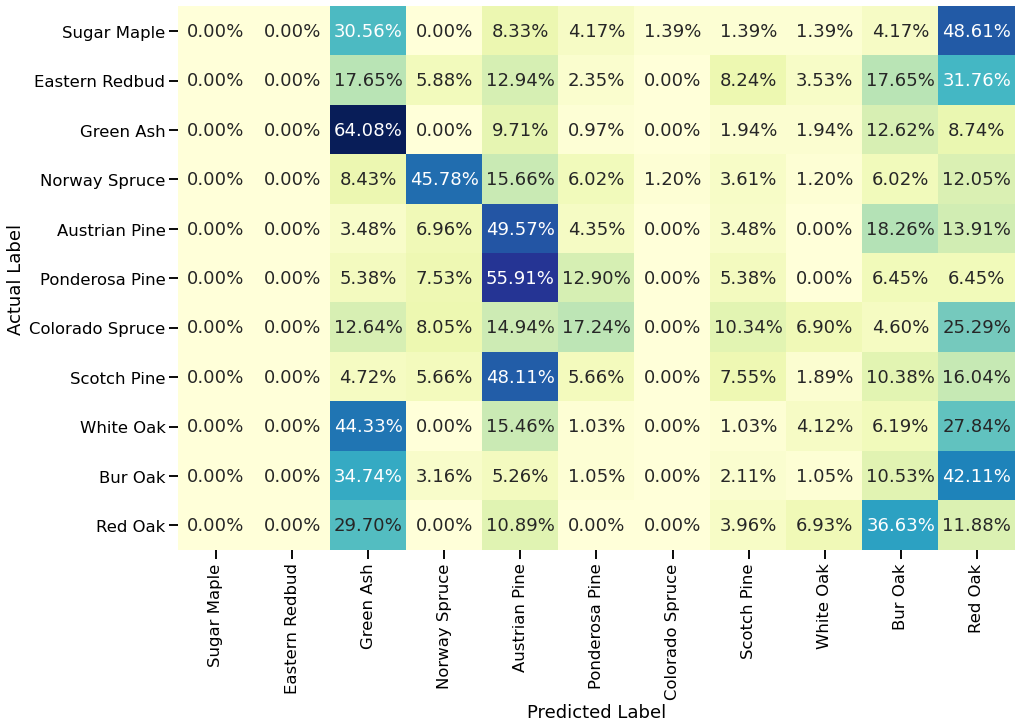

In [7]:
#prepare data for august
df_aug = df_aug.groupby(['ROIID','TARGET'], as_index = False).mean()
x_test = df_aug[df_aug.columns[3:]].values
y_test = LabelEncoder().fit_transform(df_aug.TARGET)

# #model for aug
model_name = 'canopy_hyper_ind_aug'
aug = joblib.load(glob.glob('../pixels/models/*aug.joblib')[0])
preds = aug.predict(x_test)
generate_cf(model_name,y_test,preds,nclasses, labels)

#metrics
test_accuracy = 100*(accuracy_score(y_test, preds))
aug_results =pd.DataFrame.from_dict( {"Model":[model_name], "Test Accuracy(%)":[test_accuracy]})
evals.append(aug_results)
# #model for aug_pc
model_name = 'canopy_hyper_ind_pc30_aug'
aug = joblib.load(glob.glob('../pixels/models/*pc30_aug.joblib')[0])
df_aug_pc = calculate_pcs(df_aug, x_test,30)
preds = aug.predict(df_aug_pc[df_aug_pc.columns[:-1]])
generate_cf(model_name,y_test,preds,nclasses, labels)

#metrics
test_accuracy = 100*(accuracy_score(y_test, preds))
pc30_aug_results =pd.DataFrame.from_dict( {"Model":[model_name], "Test Accuracy(%)":[test_accuracy]})
evals.append(pc30_aug_results)

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished


           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
1010  0.621663 -0.049972  0.013455  0.122660 -0.041309 -0.027897  0.030102   
1011 -1.171324 -0.058619  0.007464  0.017927 -0.015313 -0.007169  0.003458   
1012 -0.919839 -0.090653  0.047657  0.034540 -0.015364 -0.004004  0.008935   
1013 -1.319958 -0.062512 -0.017044  0.065685 -0.027919 -0.022490 -0.003402   
1014  0.052751  0.057734 -0.018118  0.048710  0.008468 -0.007387 -0.005456   

           PC8       PC9      PC10  ...      PC22      PC23      PC24  \
1010  0.004486 -0.011794 -0.001900  ... -0.001167 -0.003231 -0.002272   
1011 -0.005132  0.005034 -0.000415  ... -0.000995  0.000629 -0.001402   
1012  0.008633  0.002017 -0.002186  ... -0.002247 -0.000333 -0.000984   
1013 -0.011153  0.007562 -0.003209  ...  0.001406  0.000155  0.002377   
1014 -0.002610 -0.003230 -0.001019  ... -0.003431 -0.001269 -0.002125   

          PC25      PC26      PC27      PC28      PC29      PC30  target  
1010 -0.001093 -0

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.1s finished


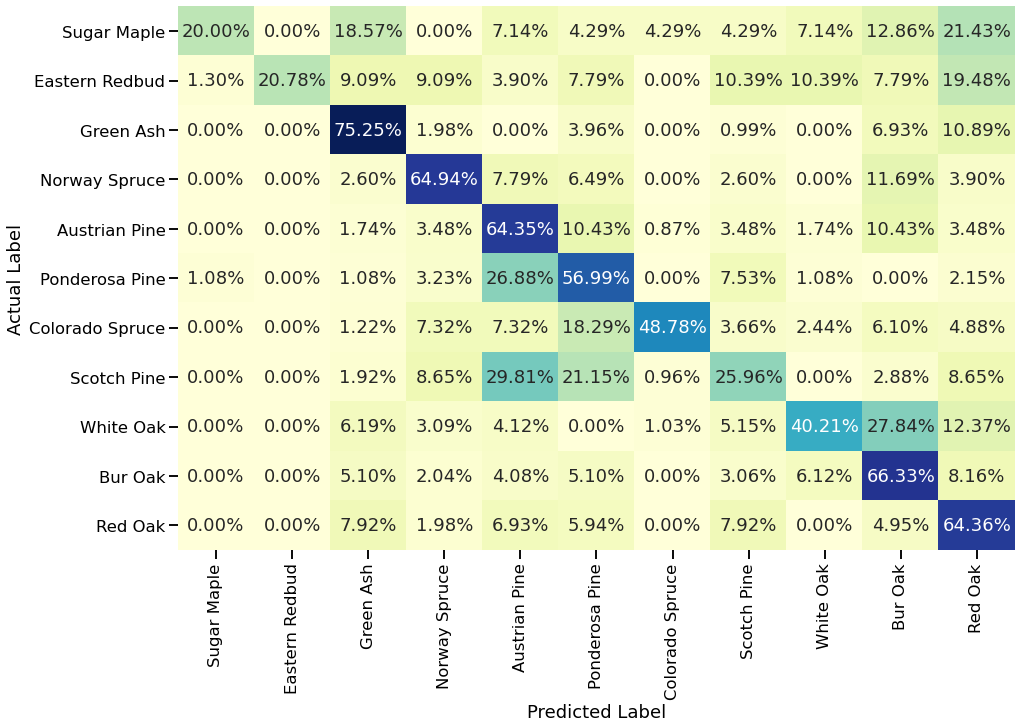

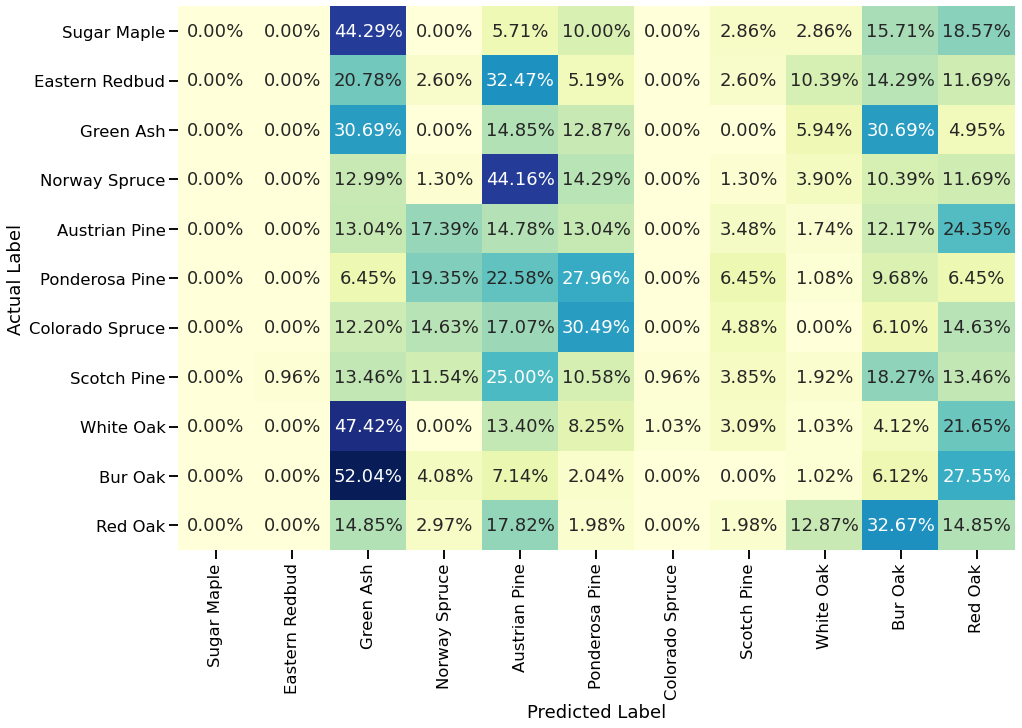

In [9]:
#prepare data for september e
df_sep = df_sep.groupby(['ROIID','TARGET'], as_index = False).mean()
x_test = df_sep[df_sep.columns[3:]].values
y_test = LabelEncoder().fit_transform(df_sep.TARGET)

# #model for aug
model_name = 'canopy_hyper_ind_sep'
sep = joblib.load(glob.glob('../pixels/models/*sep.joblib')[0])
preds = sep.predict(x_test)
generate_cf(model_name,y_test,preds,nclasses, labels)

#metrics
test_accuracy = 100*(accuracy_score(y_test, preds))
sep_results =pd.DataFrame.from_dict( {"Model":[model_name], "Test Accuracy(%)":[test_accuracy]})
evals.append(sep_results)

# #model for aug_pc
model_name = 'canopy_hyper_ind_pc30_sep'
sep = joblib.load(glob.glob('../pixels/models/*pc30_sep.joblib')[0])
df_sep_pc = calculate_pcs(df_sep, x_test,30)
preds = sep.predict(df_sep_pc[df_sep_pc.columns[:-1]])
generate_cf(model_name,y_test,preds,nclasses, labels)

#metrics
test_accuracy = 100*(accuracy_score(y_test, preds))
pc30_sep_results =pd.DataFrame.from_dict( {"Model":[model_name], "Test Accuracy(%)":[test_accuracy]})
evals.append(pc30_sep_results)

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished


           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
1019 -0.875918  0.056647 -0.055706  0.121849 -0.020540  0.012403 -0.032340   
1020 -0.625057 -0.087618 -0.047162  0.048485 -0.034202  0.002301 -0.020787   
1021  0.238728  0.022561 -0.089460  0.017733 -0.043897 -0.001558 -0.037312   
1022 -1.376023 -0.001621 -0.046936  0.060441 -0.030649 -0.007729 -0.000878   
1023 -1.411352 -0.053031  0.003008 -0.018422 -0.004299 -0.003615 -0.004109   

           PC8       PC9      PC10  ...      PC22      PC23      PC24  \
1019 -0.001472  0.001948  0.008832  ... -0.000907 -0.003309 -0.000462   
1020 -0.000964 -0.003487 -0.001429  ...  0.000593 -0.002688  0.001757   
1021 -0.006020  0.002240 -0.008809  ...  0.001669  0.003342  0.003664   
1022 -0.005307  0.006058  0.007648  ...  0.004079  0.004859  0.003534   
1023  0.002638 -0.005399  0.009640  ... -0.002520 -0.002334 -0.003488   

          PC25      PC26      PC27      PC28      PC29      PC30  target  
1019  0.001238  0

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.1s finished


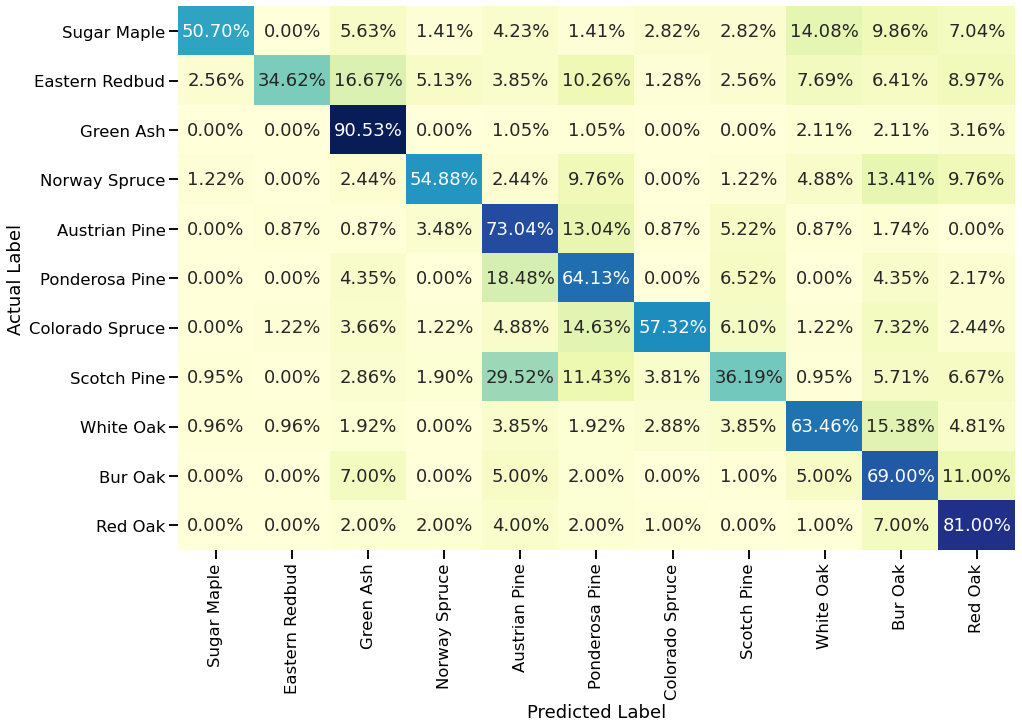

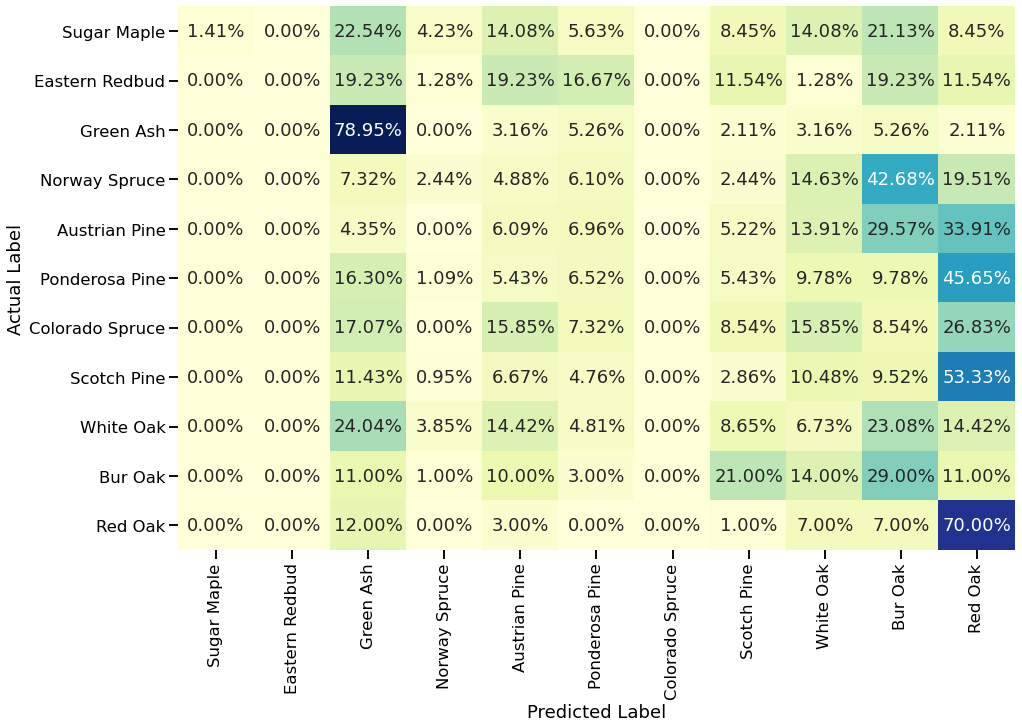

In [10]:
#prepare data for october
df_oct = df_oct.groupby(['ROIID','TARGET'], as_index = False).mean()
x_test = df_oct[df_oct.columns[3:]].values
y_test = LabelEncoder().fit_transform(df_oct.TARGET)

# #model for aug
model_name = 'canopy_hyper_ind_oct'
octb = joblib.load(glob.glob('../pixels/models/*oct.joblib')[0])
preds = octb.predict(x_test)
generate_cf(model_name,y_test,preds,nclasses, labels)
#metrics
test_accuracy = 100*(accuracy_score(y_test, preds))
oct_results =pd.DataFrame.from_dict( {"Model":[model_name], "Test Accuracy(%)":[test_accuracy]})
evals.append(oct_results)
# #model for aug_pc
model_name = 'canopy_hyper_ind_pc30_oct'
octb = joblib.load(glob.glob('../pixels/models/*pc30_oct.joblib')[0])
df_oct_pc = calculate_pcs(df_oct, x_test,30)
preds = octb.predict(df_oct_pc[df_oct_pc.columns[:-1]])
generate_cf(model_name,y_test,preds,nclasses, labels)

#metrics
test_accuracy = 100*(accuracy_score(y_test, preds))
pc30_oct_results =pd.DataFrame.from_dict( {"Model":[model_name], "Test Accuracy(%)":[test_accuracy]})
evals.append(pc30_oct_results)

In [11]:
df_results = pd.concat(evals)
df_results

,Model,Test Accuracy(%)
0,canopy_hyper_ind_aug,60.173578
0,canopy_hyper_ind_pc30_aug,19.961427
0,canopy_hyper_ind_sep,51.133005
0,canopy_hyper_ind_pc30_sep,9.950739
0,canopy_hyper_ind_oct,62.304688
0,canopy_hyper_ind_pc30_oct,19.531250


In [12]:
df_results.to_csv("canopy_hyper_ind_summary_results.csv")

In [16]:
#visualization
#load tree data with Genus on
df_tree_genus = pd.read_csv("../../../../../data/Export_Output_2_0630_Genus.txt")
dic = dict(zip(df_tree_genus.SPECIES,df_tree_genus.GENUS))

#add genus to thee dataframs 
merged_dfs = merge_images([df_aug,df_sep,df_oct])
df_aug['Genus'] = df_aug.TARGET.map(dic)
df_sep['Genus'] = df_sep.TARGET.map(dic)
df_oct['Genus'] = df_oct.TARGET.map(dic)
merged_dfs['Genus'] = merged_dfs.TARGET.map(dic)

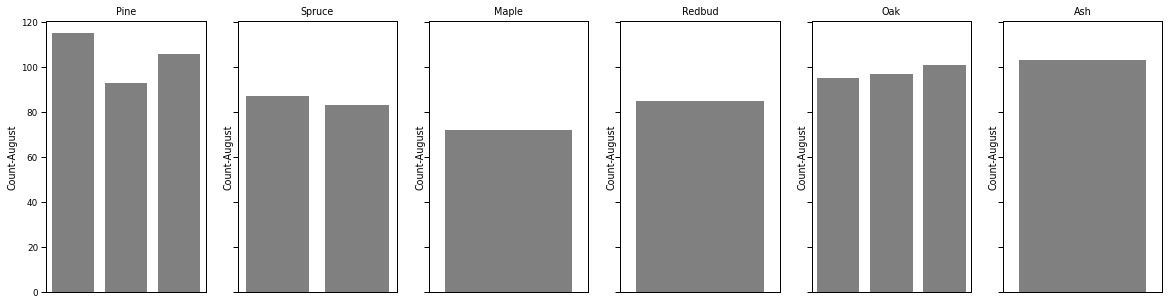

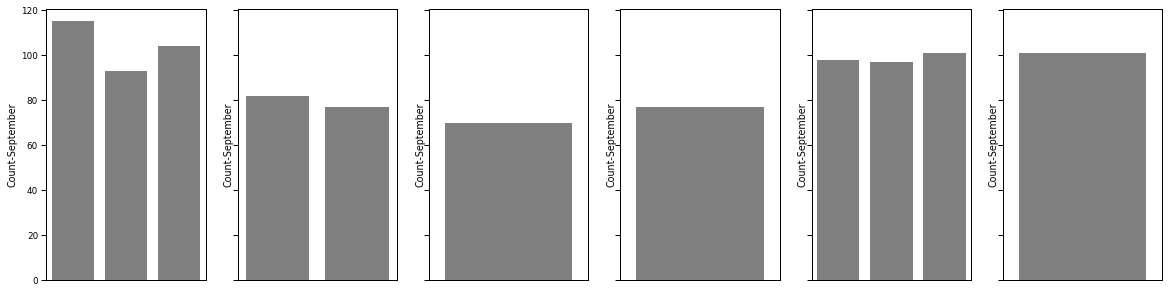

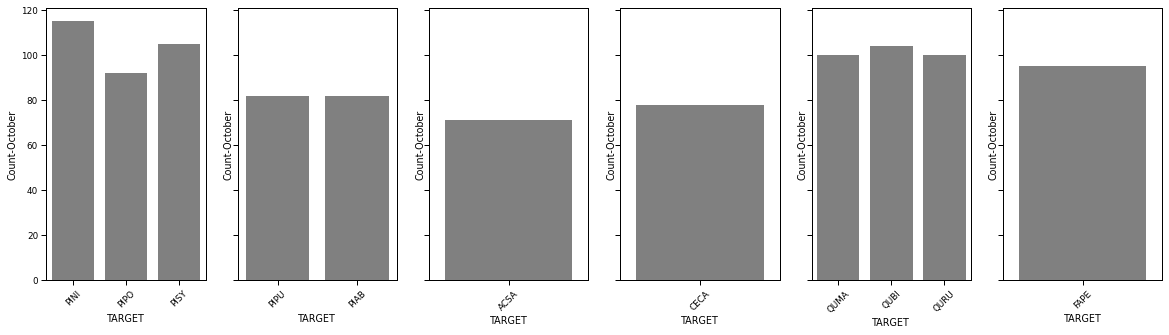

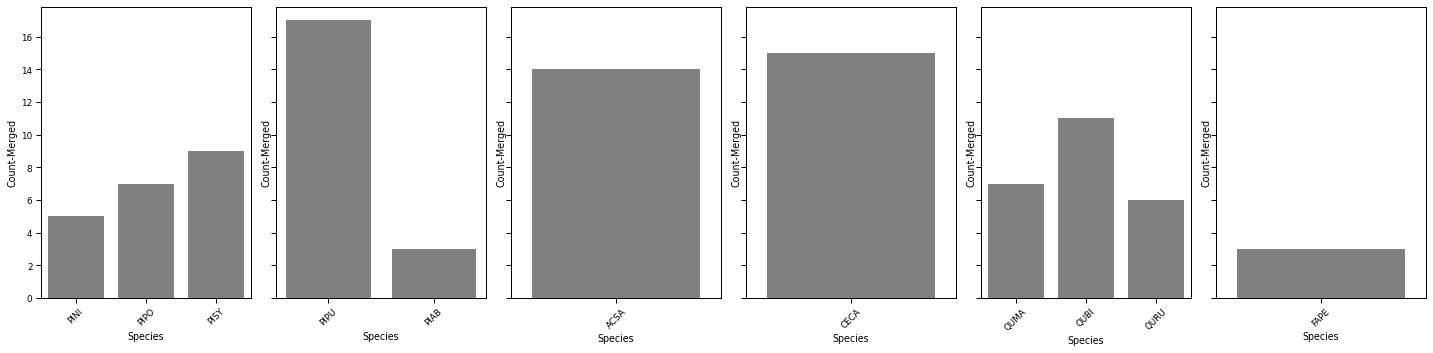

In [19]:
#visualizaing data
fig, axes = plt.subplots(1,6, figsize = (20,5), sharey= True)
sns.set_context ('paper')

#august
genera = list(set(dic.values()))
#for genus in set(dic.values()):
i = 0
while i<6:
    data = df_aug[df_aug.Genus == genera[i]]
    sns.countplot(x = 'TARGET',data =data, ax = axes[i], color = 'grey')
    axes[i].tick_params(axis = 'x',rotation = 45)
    axes[i].set_title(genera[i])
#     axes[i].set_xlabel("Species")
    axes[i].set_ylabel('Count-August')
    axes[i].xaxis.set_visible(False)
    i+=1
 
#sep
fig, axes = plt.subplots(1,6, figsize = (20,5), sharey= True)
sns.set_context ('paper')
i = 0
while i<6:
    data = df_sep[df_sep.Genus == genera[i]]
    sns.countplot(x = 'TARGET',data =data, ax = axes[i], color = 'grey')
    axes[i].tick_params(axis = 'x',rotation = 45)
#     axes[i].set_title(genera[i])
#     axes[i].set_xlabel("Species")
    axes[i].set_ylabel('Count-September')
    axes[i].xaxis.set_visible(False)
    i+=1

#oct
fig, axes = plt.subplots(1,6, figsize = (20,5), sharey= True)
sns.set_context ('paper')
i = 0
while i<6:
    data = df_oct[df_oct.Genus == genera[i]]
    sns.countplot(x = 'TARGET',data =data, ax = axes[i], color = 'grey')
    axes[i].tick_params(axis = 'x',rotation = 45)
#     axes[i].set_title(genera[i])
#     axes[i].set_xlabel("Species")
    axes[i].set_ylabel('Count-October')
    axes[i].xaxis.set_visible(True)
    i+=1
#merged
fig, axes = plt.subplots(1,6, figsize = (20,5), sharey= True)
sns.set_context ('paper')
i = 0
while i<6:
    data = merged_dfs[merged_dfs.Genus == genera[i]]
    sns.countplot(x = 'TARGET',data =data, ax = axes[i], color = 'grey')
    axes[i].tick_params(axis = 'x',rotation = 45)
#     axes[i].set_title(genera[i])
    axes[i].set_xlabel("Species")
    axes[i].set_ylabel('Count-Merged')
    i+=1   
plt.tight_layout()

In [20]:
df_aug.shape,df_sep.shape,df_oct.shape, merged_dfs.shape

((1037, 299), (1015, 299), (1024, 299), (97, 889))

In [21]:
merged_dfs.head()

,ROIID,IDwithROI,TARGET,396.33_aug,398.01_aug,399.7_aug,401.38_aug,403.07_aug,404.75_aug,406.44_aug,...,886.78,888.5,890.22,891.94,893.66,895.38,897.1,898.81,900.53,Genus
0,42,15.0,PINI,0.007845,0.007352,0.007355,0.007759,0.008638,0.010148,0.011272,...,0.300159,0.305814,0.312366,0.320500,0.329214,0.339707,0.349479,0.359145,0.369224,Pine
1,49,12.0,PINI,0.004835,0.005083,0.005639,0.006452,0.007535,0.009078,0.010243,...,0.339252,0.345378,0.353030,0.361657,0.371074,0.379457,0.389874,0.400661,0.410448,Pine
2,50,16.0,PINI,0.006529,0.006197,0.006239,0.006597,0.007294,0.008468,0.009626,...,0.345445,0.349542,0.354690,0.360777,0.367594,0.374497,0.383168,0.392868,0.403161,Pine
3,57,8.0,PINI,0.007633,0.008553,0.009493,0.010360,0.011267,0.012253,0.012633,...,0.254607,0.258233,0.262487,0.267527,0.273287,0.280100,0.287840,0.295920,0.304993,Pine
4,58,8.5,PINI,0.002969,0.003794,0.005044,0.006550,0.008475,0.010875,0.012981,...,0.348212,0.354150,0.361662,0.370712,0.382488,0.390375,0.402894,0.416556,0.430637,Pine
